### Creating the auxiliary input images

In [10]:
import os
import matplotlib.pyplot as plt
import rasterio
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point

# Directories
os.makedirs("plots", exist_ok=True)
os.makedirs("models", exist_ok=True)

# 1. Load Elevation Data
def load_rain_data(filepath):
    with rasterio.open(filepath) as src:
        rain = src.read(1)  # Load the first band
        transform = src.transform
    return rain, transform

rain, transform = load_rain_data(r"C:\Users\chari\Home\TU Delft\TU-Delft\3rd semester\DSAIE\project\CEGM2003-Water\New model\CNN_from_R\images_for_CNN\rainfall_raster_bound.tif")

# 2. Load the recharge data
clor = pd.read_csv("../Data/dat07_u.csv")
quant = "Recharge mean mm/y" 

# Drop NaNs for essential columns
clor = clor.dropna(subset=["lat", "lon", quant])


# Convert clor to a GeoDataFrame
geometry = [Point(xy) for xy in zip(clor['lon'], clor['lat'])]
clor_gdf = gpd.GeoDataFrame(clor, geometry=geometry, crs="EPSG:3577")  # WGS84 (lat/lon)



# Extract the reprojected coordinates
clor_gdf['x'] = clor_gdf.geometry.x
clor_gdf['y'] = clor_gdf.geometry.y


# 3. Extract Sample-Centered Terrain Images
def extract_sample_centered_images(clor_gdf, rain, transform, size=32):
    rows, cols = rain.shape
    half_size = size // 2
    terrain_images = []

    for _, row in clor_gdf.iterrows():
        x, y = row["x"], row["y"]
        col, row = ~transform * (x, y)
        col, row = int(col), int(row)
        
        if 0 <= row-half_size < rows and 0 <= col-half_size < cols:
            img = rain[row-half_size:row+half_size, col-half_size:col+half_size]
            if img.shape == (size, size):
                terrain_images.append(img)
            else:
                terrain_images.append(np.zeros((size, size)))  # Pad with zeros if out of bounds
        else:
            terrain_images.append(np.zeros((size, size)))  # Completely out of bounds

    return np.array(terrain_images)

# Use the updated coordinates
terrain_images = extract_sample_centered_images(clor_gdf, rain, transform)

C:\Users\chari\AppData\Local\Temp\ipykernel_47776\4151344183.py:23: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  clor = pd.read_csv("../Data/dat07_u.csv")


#### Checking the centered images

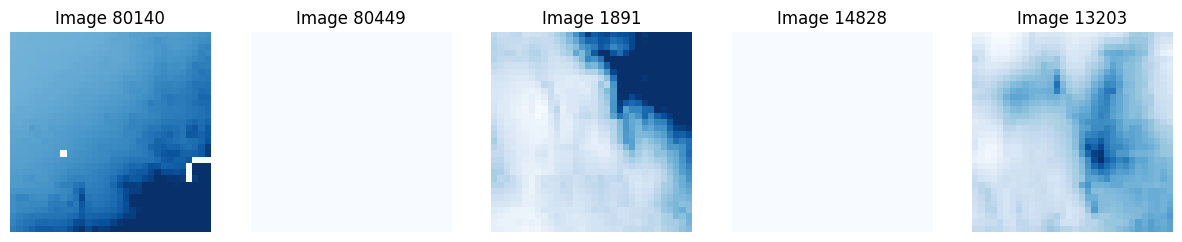

In [17]:
n = 5

# Select random images or specific indices
indices = np.random.choice(len(terrain_images), n, replace=False)

# Plot the images
fig, axs = plt.subplots(1, n, figsize=(15, 5))
for i, idx in enumerate(indices):
    axs[i].imshow(terrain_images[idx], cmap="Blues")
    axs[i].set_title(f"Image {idx}")
    axs[i].axis("off")
plt.show()

### Our network

In [ ]:
# Use neural network to learn relationship between terrain features and geochemistry ####

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Activation, SpatialDropout2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.initializers import HeNormal, Zeros
from tensorflow_probability import distributions as tfd

np.random.seed(321)
fold_size = gchem.shape[0] // 10
test = np.random.choice(gchem.shape[0], fold_size, replace=False)
val = np.random.choice(np.setdiff1d(np.arange(gchem.shape[0]), test), fold_size, replace=False)
train = np.setdiff1d(np.arange(gchem.shape[0]), np.concatenate((test, val)))

# Data Preparation --------------------------------------------------------

x_train = [imgs_ann[train, :, :], loc_ann[train, :]]
x_val = [imgs_ann[val, :, :], loc_ann[val, :]]
x_test = [imgs_ann[test, :, :], loc_ann[test, :]]

x_train[0] = x_train[0].reshape((x_train[0].shape[0], imagedim, imagedim, 1))
x_val[0] = x_val[0].reshape((x_val[0].shape[0], imagedim, imagedim, 1))
x_test[0] = x_test[0].reshape((x_test[0].shape[0], imagedim, imagedim, 1))

if logtrans:
    y_train = np.log(gchem[:, elem].astype(float))[train]
    y_val = np.log(gchem[:, elem].astype(float))[val]
    y_test = np.log(gchem[:, elem].astype(float))[test]
else:
    y_train = gchem[:, elem].astype(float)[train]
    y_val = gchem[:, elem].astype(float)[val]
    y_test = gchem[:, elem].astype(float)[test]

# Defining Model ----------------------------------------------------------
time = tf.timestamp()

dropratespat = 0.5  # match what model was trained with
dropratedense = 0.2  # match what model was trained with

kernel_ini = HeNormal()
bias_ini = Zeros()

# Convolutional stack:
conv_input = Input(shape=(imagedim, imagedim, 1), name='conv_input')

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=3, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_input)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = Conv2D(128, (3, 3), dilation_rate=1, strides=1, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(conv_output)
conv_output = Activation("relu")(conv_output)
conv_output = SpatialDropout2D(rate=dropratespat)(conv_output)

conv_output = GlobalAveragePooling2D()(conv_output)
conv_output = Flatten()(conv_output)

# Auxiliary input:
auxiliary_input = Input(shape=(3,), name='aux_input')

auxiliary_output = Dense(1920, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(auxiliary_input)
auxiliary_output = Activation("relu")(auxiliary_output)
auxiliary_output = Dropout(rate=dropratedense)(auxiliary_output)
auxiliary_output = Flatten()(auxiliary_output)

# Main output:
main_output = Concatenate()([conv_output, auxiliary_output])
main_output = Dense(1024, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(256, kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = Activation("relu")(main_output)
main_output = Dropout(rate=dropratedense)(main_output)
main_output = Dense(units=2, activation="linear", name="dist_param", kernel_initializer=kernel_ini, bias_initializer=bias_ini)(main_output)
main_output = tf.keras.layers.Lambda(lambda x: tfd.Normal(loc=x[:, 0:1], scale=1e-3 + tf.nn.softplus(0.1 * x[:, 1:2])))(main_output)

In [ ]:
# Training ----------------------------------------------------------------
# Set batch size and number of epochs
batch_size = 2**12
epochs = 1000

# Train the model with the specified parameters
history = model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    shuffle=True,
    verbose=2
    # Uncomment the following lines to use callbacks for early stopping and model checkpointing
    # callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
    #            tf.keras.callbacks.ModelCheckpoint(monitor='val_loss', save_best_only=True, save_weights_only=True,
    #                                              filepath=os.path.join(os.getcwd(), "models/modelweights.hdf5"))]
)

# Find the minimum validation loss
min_val_loss = min(history.history['val_loss'])

# Note: Python does not have a direct equivalent of R's Sys.time() - time
# You would need to manually track the start and end time using datetime or time module

# Find the epoch with the minimum validation loss
best_epoch = history.history['val_loss'].index(min_val_loss)

# Save and load model weights
model.save_weights(os.path.join(os.getcwd(), "models/modelweights.hdf5"))
model.load_weights(os.path.join(os.getcwd(), "models/modelweights.hdf5"))

# Create a new model for predictions using the 'dist_param' layer
meanmodel = tf.keras.Model(
    inputs=model.input,
    outputs=model.get_layer("dist_param").output
)

# Save and load the mean model
meanmodel.save(os.path.join(os.getcwd(), "models/meanmodel"))
meanmodel = tf.keras.models.load_model(os.path.join(os.getcwd(), "models/meanmodel"))

# Create a DataFrame for holdout predictions and observations
holdout = pd.DataFrame({'obs': y_test, 'preds': meanmodel.predict(x_test)[:, 0]})

# Calculate and print R squared and RMSE
print(f"R squared = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 3)}")
print(f"RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 3)}")


In [ ]:

# Plot observed vs predicted values
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 8))
sns.scatterplot(x='obs', y='preds', data=holdout, alpha=0.1)
plt.plot([holdout['obs'].min(), holdout['obs'].max()], [holdout['obs'].min(), holdout['obs'].max()], 'k--')
plt.xlabel(f"Observed log({elem})" if logtrans else f"observed {elem}")
plt.ylabel(f"Predicted log({elem})" if logtrans else f"predicted {elem}")
plt.title(f"R² = {round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)}     RMSE = {round(np.sqrt(np.mean((holdout['preds'] - holdout['obs'])**2)), 2)}")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"plots/{elem}_mean_holdout_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)

# Prepare training history data for plotting
trainhist = pd.DataFrame(history.history)[['loss', 'val_loss']]
trainhist.columns = ['training', 'testing']
trainhist['epoch'] = range(1, len(trainhist) + 1)

# Melt the training history data for plotting
trainhist_melted = trainhist.melt(id_vars='epoch', var_name='dataset', value_name='NLL')

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 5))
sns.lineplot(x='epoch', y='NLL', hue='dataset', data=trainhist_melted)
plt.ylim(0, trainhist['testing'].quantile(0.999))
plt.savefig(f"plots/{elem}_training_{round(np.corrcoef(holdout['preds'], holdout['obs'])[0, 1]**2, 2)*100}.png", dpi=300)
